<a href="https://colab.research.google.com/github/Avisineth/Sale_Forecast-2013-2017/blob/main/Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential

Import dataset

In [4]:
data = pd.read_csv('SalesData.csv')
data.head(5)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Check null values

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57967 entries, 0 to 57966
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    57967 non-null  object
 1   store   57967 non-null  int64 
 2   item    57967 non-null  int64 
 3   sales   57967 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.8+ MB


Drop the store and item column

In [6]:
data = data.drop(['store','item'], axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57967 entries, 0 to 57966
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    57967 non-null  object
 1   sales   57967 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 905.9+ KB


In [8]:
data['date'] = pd.to_datetime(data['date'])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57967 entries, 0 to 57966
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    57967 non-null  datetime64[ns]
 1   sales   57967 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 905.9 KB


In [10]:
data['date'] = data['date'].dt.to_period("M")
monthly_data = data.groupby('date').sum().reset_index()

In [12]:
monthly_data['date'] = monthly_data['date'].dt.to_timestamp()

In [14]:
monthly_data.head(10)

,date,sales
0,2013-01-01,21332
1,2013-02-01,21556
2,2013-03-01,28791
3,2013-04-01,31696
4,2013-05-01,35647
5,2013-06-01,37147
6,2013-07-01,39860
7,2013-08-01,35927
8,2013-09-01,32035
9,2013-10-01,30515


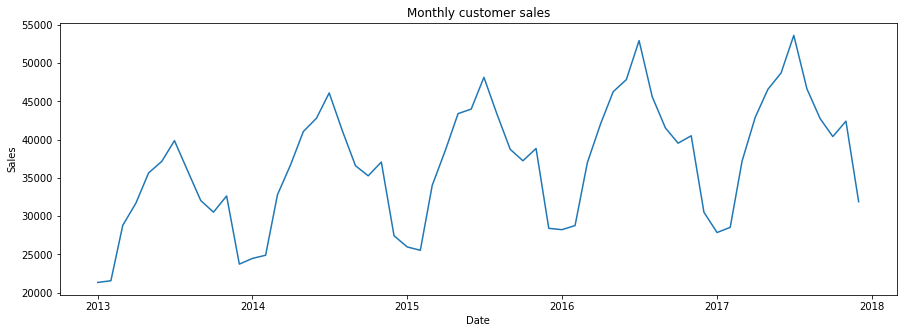

In [18]:
plt.figure(figsize=(15,5))
plt.plot(monthly_data['date'], monthly_data['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly customer sales")
plt.show()

In [19]:
monthly_data['sales_diff'] = monthly_data['sales'].diff()
monthly_data = monthly_data.dropna()
monthly_data.head(10)

,date,sales,sales_diff
1,2013-02-01,21556,224.0
2,2013-03-01,28791,7235.0
3,2013-04-01,31696,2905.0
4,2013-05-01,35647,3951.0
5,2013-06-01,37147,1500.0
6,2013-07-01,39860,2713.0
7,2013-08-01,35927,-3933.0
8,2013-09-01,32035,-3892.0
9,2013-10-01,30515,-1520.0
10,2013-11-01,32634,2119.0
